# Emotion classification using the RAVDESS dataset

The RAVDESS contains 7356 files. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. Validation data is open-access, and can be downloaded along with our paper from PLOS ONE.

***Description***

The dataset contains the complete set of 7356 RAVDESS files (total size: 24.8 GB). Each of the 24 actors consists of three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound).  Note, there are no song files for Actor_18.

***Data***

For this task, I have used 4948 samples from the RAVDESS dataset.

The samples comes from:

- Audio-only files;
- Video + audio files: I have extracted the audio from each file using the script Mp4ToWav.py that you can find in the main directory of the project.

***License information***

The RAVDESS is released under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License, CC BY-NA-SC 4.0

***File naming convention***

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

***Filename identifiers***

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
- Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 02-01-06-01-02-01-12.mp4 

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement “dogs” (02)
- 1st Repetition (01)
- 12th Actor (12)
- Female, as the actor ID number is even.

# Analysis

We are using Colab, a Google Cloud environment for jupyter, so we need to import our files from Google Drive and then install LibROSA, a python package for music and audio analysis.

After the import, we will plot the signal of the first file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/content/drive/MyDrive/Datasets/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


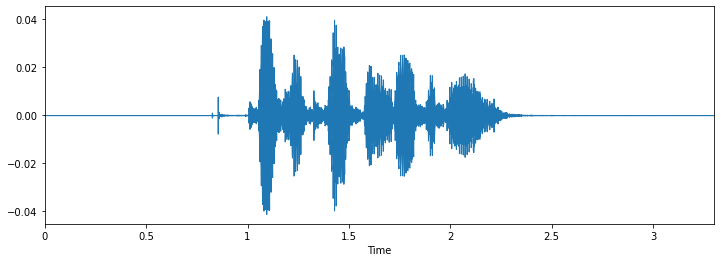

In [ ]:
% pylab inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

# Load all files

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file (see the introductory section of this notebook to see the naming convention of the files of this dataset).

In [ ]:
import time

path = '/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/features'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 361.5156126022339 seconds ---


In [ ]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [ ]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((5252, 40), (5252,))

In [ ]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/our_test_files'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [ ]:
# Loading saved models
import joblib
X = joblib.load('/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/joblib_features/X.joblib')
y = joblib.load('/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/joblib_features/y.joblib')

# Decision Tree Classifier

To make a first attempt in accomplishing this classification task I chose a decision tree:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
predictions = dtree.predict(X_test)

In [ ]:
predictions

array([7, 1, 1, ..., 3, 5, 3])

Let's go with our classification report.

Before we start, a quick reminder of the classes we are trying to predict:

emotions = {
    "neutral": "0",
    "calm": "1",
    "happy": "2",
    "sad": "3",
    "angry": "4", 
    "fearful": "5", 
    "disgust": "6", 
    "surprised": "7"
}

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       192
           1       0.60      0.52      0.56       123
           2       0.64      0.63      0.63       264
           3       0.71      0.66      0.68       275
           4       0.70      0.69      0.70       252
           5       0.59      0.66      0.62       241
           6       0.68      0.69      0.69       197
           7       0.59      0.61      0.60       190

    accuracy                           0.66      1734
   macro avg       0.66      0.65      0.66      1734
weighted avg       0.66      0.66      0.66      1734



# Random Forest

In this second approach, I switched to a random forest classifier and I made a gridsearch to make some hyperparameters tuning.

The gridsearch is not shown in the code below otherwise the notebook will require too much time to run.

# Neural network

Let's build our neural network!

To do so, we need to expand the dimensions of our array, adding a third one using the numpy "expand_dims" feature.

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape, x_testcnn.shape

((3518, 40, 1), (1734, 40, 1))

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop 

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


With *model.summary* we can see a recap of what we have build:

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 40, 128)           768       
                                                                 
 activation_15 (Activation)  (None, 40, 128)           0         
                                                                 
 dropout_10 (Dropout)        (None, 40, 128)           0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 5, 128)            82048     
                                                                 
 activation_16 (Activation)  (None, 5, 128)            0         
                                                      

Now we can compile and fit our model:

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Epoch 1/1000
220/220 [==============================] - 13s 6ms/step - loss: 6.0139 - accuracy: 0.1777 - val_loss: 2.0117 - val_accuracy: 0.3472
Epoch 2/1000
220/220 [==============================] - 1s 5ms/step - loss: 3.9672 - accuracy: 0.2706 - val_loss: 1.5860 - val_accuracy: 0.4319
Epoch 3/1000
220/220 [==============================] - 1s 5ms/step - loss: 2.9413 - accuracy: 0.3425 - val_loss: 1.4691 - val_accuracy: 0.5121
Epoch 4/1000
220/220 [==============================] - 1s 5ms/step - loss: 2.3235 - accuracy: 0.3906 - val_loss: 1.3003 - val_accuracy: 0.5306
Epoch 5/1000
220/220 [==============================] - 1s 5ms/step - loss: 1.8610 - accuracy: 0.4471 - val_loss: 1.2530 - val_accuracy: 0.5692
Epoch 6/1000
220/220 [==============================] - 1s 4ms/step - loss: 1.6005 - accuracy: 0.4920 - val_loss: 1.2808 - val_accuracy: 0.5640
Epoch 7/1000
220/220 [==============================] - 1s 5ms/step - loss: 1.5038 - accuracy: 0.5048 - val_loss: 1.1890 - val_accuracy

Let's plot the loss:

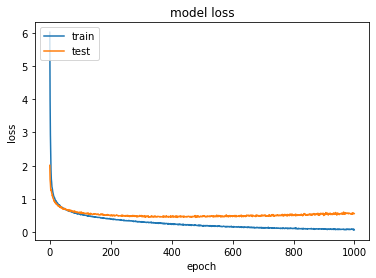

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
%history

from google.colab import drive
drive.mount('/content/drive')
!pip install librosa
import librosa
from librosa import display

data, sampling_rate = librosa.load('/content/drive/MyDrive/Datasets/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
% pylab inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)
# Loading saved models

X = joblib.load('/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/joblib_features/X.joblib')
y = joblib.load('/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/joblib_features/y.joblib')
# Loading saved models
import joblib
X = joblib.load('/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/joblib_features/X.joblib')
y = joblib.load('/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/joblib_features/y.joblib')
from sklearn.model_selection import train_test_split

X



And now let's plot the accuracy:

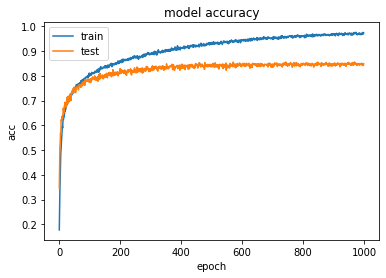

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's now create a classification report to review the f1-score of the model per class.
To do so, we have to:
- Create a variable predictions that will contain the model.predict_classes outcome
- Convert our y_test (array of strings with our classes) to an array of int called new_Ytest, otherwise it will not be comparable to the predictions by the classification report.

In [ ]:
predictions=model.predict(x_testcnn) 
classes_x=np.argmax(predictions,axis=1)

In [ ]:
classes_x

array([3, 3, 3, ..., 1, 6, 2])

In [ ]:
y_test

array([3, 3, 3, ..., 1, 6, 2], dtype=int32)

In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
new_Ytest

array([3, 3, 3, ..., 1, 6, 2])

Okay, now we can display the classification report:

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, classes_x)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       192
           1       0.71      0.89      0.79       123
           2       0.88      0.82      0.85       264
           3       0.81      0.84      0.82       275
           4       0.87      0.85      0.86       252
           5       0.81      0.87      0.84       241
           6       0.87      0.84      0.86       197
           7       0.89      0.85      0.87       190

    accuracy                           0.85      1734
   macro avg       0.85      0.85      0.85      1734
weighted avg       0.85      0.85      0.85      1734



And now, the confusion matrix: it will show us the misclassified samples

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, classes_x)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[164  11   0  13   1   1   1   1]
 [  2 109   5   4   2   1   0   0]
 [  1  18 217   3   9   9   4   3]
 [  3   7   6 230   3  20   3   3]
 [  1   2   9   7 214   8   7   4]
 [  0   1   3  20   3 209   3   2]
 [  0   3   3   4   7   7 166   7]
 [  1   2   5   4   6   3   7 162]]


# Save the model

In [ ]:
model_name = 'Emotion_Voice_Detection_Model66.h5'
save_dir = '/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/our_test_files'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/our_test_files/Emotion_Voice_Detection_Model66.h5 


# Reloading the model to test it

In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/emotion-classification-from-audio-files/our_test_files/Emotion_Voice_Detection_Model66.h5')
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 40, 128)           768       
                                                                 
 activation_15 (Activation)  (None, 40, 128)           0         
                                                                 
 dropout_10 (Dropout)        (None, 40, 128)           0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 5, 128)            82048     
                                                                 
 activation_16 (Activation)  (None, 5, 128)            0         
                                                      

# Checking the accuracy of the loaded model

In [ ]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

55/55 [==============================] - 0s 2ms/step - loss: 0.5627 - accuracy: 0.8483
Restored model, accuracy: 84.83%


# Thank you for your attention! To be continued..